In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [2]:
data = yf.download("^GSPC", start="2020-03-13", end="2021-03-13")

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-13,2569.989990,2711.330078,2492.370117,2711.020020,2711.020020,8258670000
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000
2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000
2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000
2021-03-10,3891.989990,3917.350098,3885.729980,3898.810059,3898.810059,5827250000
2021-03-11,3915.540039,3960.270020,3915.540039,3939.340088,3939.340088,5300010000
2021-03-12,3924.520020,3944.989990,3915.209961,3943.340088,3943.340088,4469240000


In [5]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 3943.34


In [8]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [9]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 29.12 %


In [10]:
VIX = yf.download("^VIX", start="2020-03-13", end="2021-03-13")

[*********************100%***********************]  1 of 1 completed


In [11]:
vix = VIX['Adj Close'][-1]
print('The market volatility is', round(vix,2), '%')

The market volatility is 20.69 %


In [12]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [13]:
K = 4000
T = 9/12
r = 0.0171

In [14]:
call = euro_option_bs(S, K, T, r, vol, 'call')
print('The BS call price is', round(call,2))

The BS call price is 393.14


In [15]:
put = euro_option_bs(S, K, T, r, vol, 'put')
print('The BS put price is', round(put,2))

The BS put price is 398.83


In [16]:
SP500 = yf.Ticker("^GSPC")

In [17]:
opt = SP500.option_chain('2021-12-17')
call1 = opt.calls.lastPrice[opt.calls.strike == K]
print('The Market call price is', float(call1.values))

The Market call price is 212.43


In [18]:
put1 = opt.puts.lastPrice[opt.puts.strike == K]
print('The Market put price is', float(put1.values))

The Market put price is 318.61


In [19]:
K = np.linspace(3000,4000,11)
T = [1/52, 2/52, 1/12, 2/12, 1/4, 1/2, 1]

In [20]:
call = np.zeros((len(T),len(K)))
for i in range(len(T)):
    for j in range(len(K)):
        call[i,j] = euro_option_bs(S, K[j], T[i], r, vix*0.01, 'call')

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

strike, ttm = np.meshgrid(K, T)

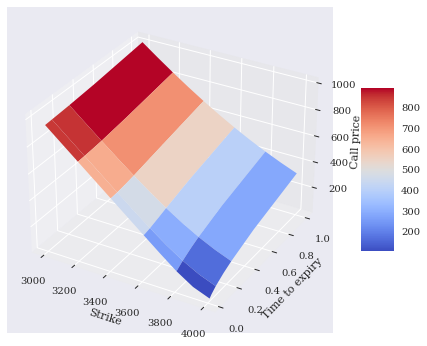

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(strike, ttm, call, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Strike')
ax.set_ylabel('Time to expiry')
ax.set_zlabel('Call price')
fig.colorbar(surf, shrink=0.5, aspect=5);